In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mstats
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
%matplotlib inline
plt.style.use("ggplot")

In [2]:
data = pd.read_csv('./input/data-ss1.txt')
data.head()

,X,Y
0,1,11.2
1,2,11.0
2,3,11.3
3,4,10.8
4,5,10.8


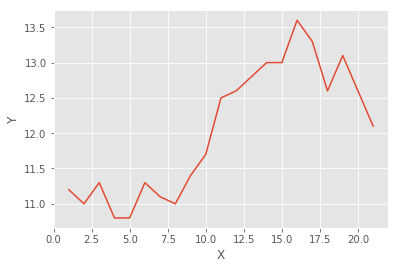

In [3]:
sns.lineplot(data=data, x='X', y='Y')

In [4]:
stan_model = """

data {
  int T;
  int T_pred;
  vector[T] Y;
}

parameters {
  vector[T] mu;
  real<lower=0> s_mu;
  real<lower=0> s_Y;
}

model {
  mu[3:T] ~ normal(2 * mu[2:(T-1)] - mu[1:(T-2)], s_mu);
  Y ~ normal(mu, s_Y);
}

generated quantities {
  vector[T+T_pred] mu_all;
  vector[T_pred] y_pred;
  mu_all[1:T] = mu;
  for (t in 1:T_pred){
    mu_all[T+t] = normal_rng(2* mu_all[T+t-1] - mu_all[T+t-2], s_mu);
    y_pred[t] = normal_rng(mu_all[T+t], s_Y);  
  }
}

"""

In [5]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_df741779093e663609b819f9f4fb54d7 NOW.


In [6]:
stan_data = {}
stan_data['T'] = data.shape[0]
stan_data['T_pred'] = 3
stan_data['Y'] = data['Y']

In [7]:
fit = sm.sampling(stan_data)

In [8]:
fit

Inference for Stan model: anon_model_df741779093e663609b819f9f4fb54d7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]       11.17  3.5e-3   0.22  10.73  11.03  11.16  11.31   11.6   3998    1.0
mu[2]        11.1  2.6e-3   0.16  10.77  10.99   11.1   11.2  11.42   3834    1.0
mu[3]       11.05  2.8e-3   0.15  10.74  10.95  11.05  11.15  11.35   2967    1.0
mu[4]       10.96  2.6e-3   0.15  10.67  10.86  10.96  11.06  11.27   3371    1.0
mu[5]       10.96  2.7e-3   0.15  10.67  10.86  10.96  11.06  11.26   3148    1.0
mu[6]       11.04  2.9e-3   0.15  10.76  10.95  11.04  11.14  11.35   2658    1.0
mu[7]        11.1  2.8e-3   0.15  10.81   11.0   11.1  11.19   11.4   2798    1.0
mu[8]       11.21  3.9e-3   0.16  10.89   11.1  11.21  11.31  11.52   1730    1.0
mu[9]       11.47  3.5e-3   0.16  11.15  11.36  11.47  11.57  11.77   204

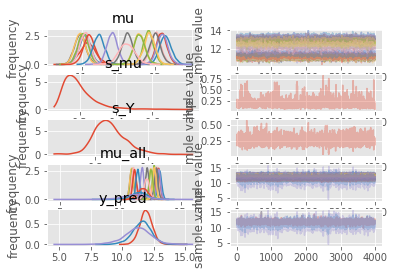

In [9]:
fig = fit.plot()

In [10]:
sample_mu = fit.extract('mu_all')['mu_all']

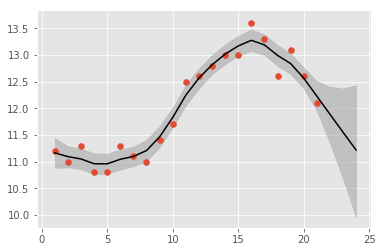

In [11]:
lower80, upper80 = mstats.mquantiles(sample_mu, [0.1, 0.9], axis=0)
x = np.arange(data.shape[0] + 3) + 1
y = np.mean(sample_mu, axis=0) 

plt.plot(x, y, color='black')
plt.fill_between(x, lower80, upper80, alpha=0.6, color='darkgray')

plt.scatter(data['X'], data['Y'])